## Assignment 2: Nearest Neighbours & Decision Trees

In [34]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from imblearn.under_sampling import TomekLinks


## Analysis

In [35]:
raw_df = pd.read_csv("../forestCover.csv", na_values="?")
raw_df = raw_df.rename(columns={"Observation_ID":"Water_Level" , "Water_Level":"Observation_ID"})
display(raw_df)

,Elevation,Aspect,Facet,Slope,Inclination,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,...,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Observation_ID,Water_Level,Cover_Type
0,3208920,166,415.394727,6.0,0.691628,408,62,3137,225,242,...,0,0,0,0,0,0,0,2,1,2
1,2789020,137,343.302186,9.0,0.621245,30,2,1040,235,237,...,0,0,0,0,0,0,0,3,1,3
2,3384615,357,894.231390,9.0,-0.266086,362,15,3113,207,225,...,0,0,0,0,0,0,0,4,1,1
3,3348150,148,371.346939,6.0,0.786375,247,50,1207,228,240,...,0,0,0,0,0,0,0,5,1,2
4,3061955,124,310.783430,11.0,-0.335685,170,19,1595,238,232,...,0,0,0,0,0,0,0,6,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,3236545,117,293.274632,17.0,0.257413,60,0,626,247,222,...,0,0,0,0,0,0,0,581009,1,2
581008,3751475,321,805.501719,6.0,-0.479762,272,19,2906,204,234,...,0,0,0,0,0,1,0,581010,1,1
581009,2855320,72,180.453289,6.0,0.946018,0,0,1719,227,228,...,0,0,0,0,0,0,0,581011,1,6
581010,3004495,100,250.901923,7.0,0.113070,0,0,2067,231,231,...,0,0,0,0,0,0,0,581012,1,2


In [36]:
raw_df["Cover_Type"].value_counts()


Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64

In [37]:
na_col = raw_df.columns[raw_df.isna().any()]
print(na_col)

Index(['Slope'], dtype='object')


In [38]:
raw_df["Slope"].isna().sum()

np.int64(298)

## Data processing
The following are data issues in the datset and need to be adressed. 
- There remain features with missing values, with missing values indicated by the character symbol `?'.
- The Facet feature is correlated with the Aspect feature.
- The Inclination feature contains only noisy values.
- There remain features with outliers.
- There remain features with numeric ranges that differ signifcantly from one another.
- There are numerical and categorical features.
- Feature Water Level has cardinality of one.
- Feature Observation ID has a unique value for each observation.
- The class distribution remains skew.

In [39]:
print(f"Corr of Inclination and Cover: {raw_df['Inclination'].corr(raw_df['Cover_Type'])}")
print(f"Corr of aspect and facet: {raw_df['Facet'].corr(raw_df['Aspect'])}")
print(f"Cardinality of water level: {raw_df['Water_Level'].nunique()}")
print(f"Cardinality of obs id: {raw_df['Observation_ID'].nunique()}")


Corr of Inclination and Cover: 0.0002417782055169697
Corr of aspect and facet: 0.9999980536139016
Cardinality of water level: 1
Cardinality of obs id: 581012


In [40]:
df = raw_df.drop(columns={'Facet','Water_Level','Observation_ID', 'Inclination' })


In [41]:
na_rows = df.index[df.isna().any(axis=1)]



na_proportions = (df["Cover_Type"][na_rows].value_counts() /  df["Cover_Type"].value_counts() * 100).round(3)
print(na_proportions)




Cover_Type
1    0.045
2    0.055
3    0.053
4    0.036
5    0.021
6    0.069
7    0.054
Name: count, dtype: float64


In [42]:
df.dropna()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,3208920,166,6.0,408,62,3137,225,242,151,2366,...,0,0,0,0,0,0,0,0,0,2
1,2789020,137,9.0,30,2,1040,235,237,133,1804,...,0,0,0,0,0,0,0,0,0,3
2,3384615,357,9.0,362,15,3113,207,225,156,295,...,0,0,0,0,0,0,0,0,0,1
3,3348150,148,6.0,247,50,1207,228,240,145,2405,...,0,0,0,0,0,0,0,0,0,2
4,3061955,124,11.0,170,19,1595,238,232,124,2837,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,3236545,117,17.0,60,0,626,247,222,98,2309,...,0,0,0,0,0,0,0,0,0,2
581008,3751475,321,6.0,272,19,2906,204,234,169,2059,...,0,0,0,0,0,0,0,1,0,1
581009,2855320,72,6.0,0,0,1719,227,228,136,2922,...,0,0,0,0,0,0,0,0,0,6
581010,3004495,100,7.0,0,0,2067,231,231,133,1260,...,0,0,0,0,0,0,0,0,0,2


There is little correlation between missingness and the covertype, the most missing instances are fall into class 2 which is most common, therefore we can drop na columns

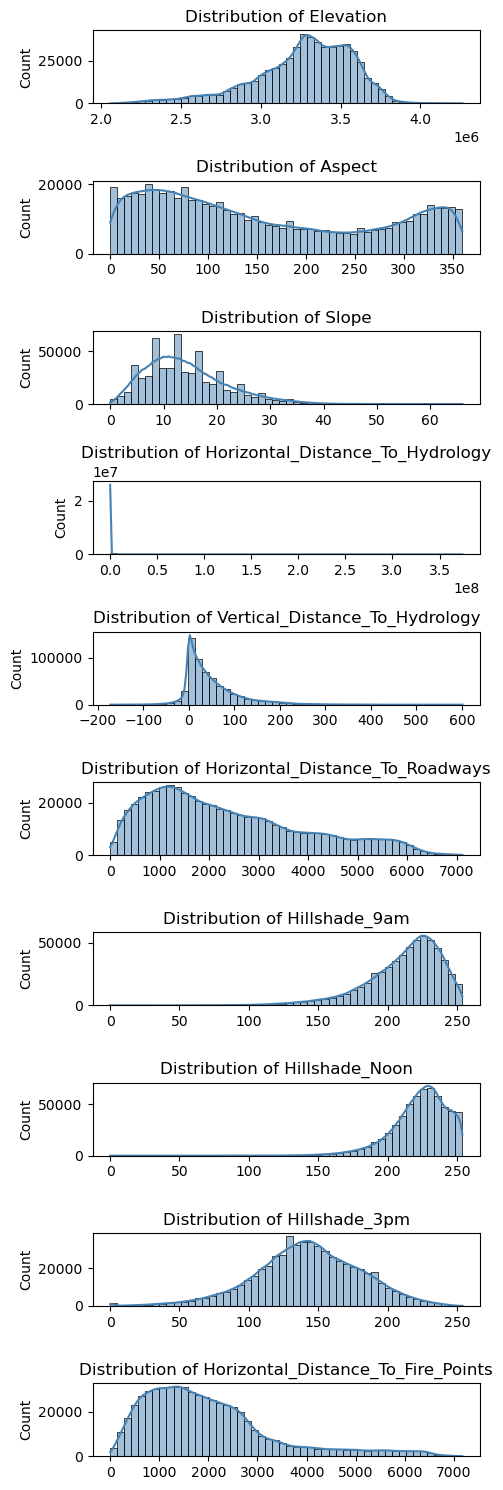

In [43]:
continuous_features = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

# Plot distributions
fig, axes = plt.subplots(len(continuous_features), 1, figsize=(5, 15))

for i, col in enumerate(continuous_features):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [44]:
df["Aspect"].describe()

count    581012.000000
mean        155.656807
std         111.913721
min           0.000000
25%          58.000000
50%         127.000000
75%         260.000000
max         360.000000
Name: Aspect, dtype: float64

### KNN dataframe

In [45]:
outlier_features = [
    "Horizontal_Distance_To_Hydrology",
    "Hillshade_Noon",
    "Vertical_Distance_To_Hydrology",
]

def clamp_series(s, lower_q=0.01, upper_q=0.99):
    lower, upper = s.quantile([lower_q, upper_q])
    return s.clip(lower, upper)

# apply clamping
for col in outlier_features:
    df[col] = clamp_series(df[col], 0.01, 0.99)


In [ ]:


continuous_features = [
    "Elevation",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]

knn_df = df.copy()




# --- Robust scaling for distance-based kNN (handles outliers better than z-score)
scaler = MinMaxScaler()
knn_df[continuous_features] = scaler.fit_transform(knn_df[continuous_features])

# --- Cyclical encoding for Aspect (DO NOT scale these)
knn_df["Aspect_rad"] = np.deg2rad(knn_df["Aspect"])
knn_df["Aspect_sin"] = np.sin(knn_df["Aspect_rad"])
knn_df["Aspect_cos"] = np.cos(knn_df["Aspect_rad"])
knn_df = knn_df.drop(columns=["Aspect", "Aspect_rad"])

# Final list for plotting
plot_features = continuous_features + ["Aspect_sin", "Aspect_cos"]

# --- Plot
n = len(plot_features)
fig, axes = plt.subplots(n, 1, figsize=(6, 2.2*n), constrained_layout=True)

for i, col in enumerate(plot_features):
    sns.histplot(knn_df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")

plt.show()

In [ ]:
knn_df["Soil_Type1"] = (knn_df["Soil_Type1"] == "positive").astype(int)


In [ ]:
knn_df.isna().any()

Elevation                             False
Slope                                  True
Horizontal_Distance_To_Hydrology      False
Vertical_Distance_To_Hydrology        False
Horizontal_Distance_To_Roadways       False
Hillshade_9am                         False
Hillshade_Noon                        False
Hillshade_3pm                         False
Horizontal_Distance_To_Fire_Points    False
Wilderness_Area1                      False
Wilderness_Area2                      False
Wilderness_Area3                      False
Wilderness_Area4                      False
Soil_Type1                            False
Soil_Type2                            False
Soil_Type3                            False
Soil_Type4                            False
Soil_Type5                            False
Soil_Type6                            False
Soil_Type7                            False
Soil_Type8                            False
Soil_Type9                            False
Soil_Type10                     

## Tomek links

In [ ]:
y = knn_df["Cover_Type"]

# Features (everything else after preprocessing)
X = knn_df.drop(columns=["Cover_Type"])

# Train/test split (stratify keeps class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
obj_cols = X_train.select_dtypes(include=['object', 'string', 'category']).columns
print("Non-numeric columns in X_train:", list(obj_cols))
print({c: X_train[c].unique()[:5] for c in obj_cols}) 

Non-numeric columns in X_train: []
{}


In [ ]:
tl = TomekLinks(sampling_strategy="auto")  # "auto" = remove majority samples
X_train_tl, y_train_tl = tl.fit_resample(X_train, y_train)

print("Before Tomek Links:", y_train.value_counts())
print("After Tomek Links:", pd.Series(y_train_tl).value_counts())

ValueError: Input X contains NaN.
TomekLinks does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Modeling

In [ ]:
# Initialize with some k (say 5) and Euclidean distance
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")

# Fit
knn.fit(X_train, y_train)

# Accuracy
train_acc = knn.score(X_train, y_train)
test_acc = knn.score(X_test, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")